In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

In [78]:
tf.random.set_seed(23)

In [79]:
# Cargar y Preprocesar el Dataset
dataset_dir = "../datasets"
image_size = (460, 440)  # MobileNetV3 espera imágenes de 440x440
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=True,
    follow_links=False,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

# Obtener los nombres de las clases (ordenados por el directorio)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Clases detectadas: {class_names}")
print(f"Número de clases: {num_classes}")


Found 754 files belonging to 8 classes.
Found 93 files belonging to 8 classes.
Found 96 files belonging to 8 classes.
Clases detectadas: ['apamate', 'araguaney', 'arbolada-mango', 'caoba', 'ceiba', 'orquidea', 'roble', 'saman']
Número de clases: 8


In [80]:
def pad_and_top_crop(image, label, final_size=440):
    # Get current shape
    shape = tf.shape(image)
    height, width = shape[0], shape[1]
    # Make sure the image is at least final_size x final_size
    max_side = tf.maximum(tf.maximum(height, width), final_size)
    pad_height = max_side - height
    pad_width = max_side - width
    image = tf.image.pad_to_bounding_box(
        image,
        offset_height=pad_height // 2,
        offset_width=pad_width // 2,
        target_height=max_side,
        target_width=max_side
    )
    # Now crop to final_size x final_size from the top-left corner
    image = tf.image.crop_to_bounding_box(
        image,
        offset_height=0,
        offset_width=0,
        target_height=final_size,
        target_width=final_size
    )
    return image, label

# Usa tf.image.resize_with_pad para asegurar tamaño y padding correcto usando image_size
def resize_with_pad(image, label, final_size=image_size):
    image = tf.image.resize_with_pad(image, final_size[0], final_size[1])
    return image, label

# Aplica la función a tus datasets
train_ds = train_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Luego puedes seguir con tu data_augmentation y resize normal
data_augmentation = keras.Sequential([
    layers.Resizing(image_size[0], image_size[1]),  # Redimensiona a 460x440 después del padding
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

In [82]:
# Aplicar aumento solo al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [83]:
# Optimizar el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Visualizar algunas imágenes de train, val y test después del preprocesamiento
import matplotlib.pyplot as plt

def show_batch(dataset, title, n=6):
    plt.figure(figsize=(15, 3))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            img = images[i].numpy().astype("uint8")
            plt.imshow(img)
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Ejemplos de train_ds")
show_batch(val_ds, "Ejemplos de val_ds")
show_batch(test_ds, "Ejemplos de test_ds")

In [84]:
# Cargar MobileNetV3
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False  # No actualizar capas inferiores en las primeras épocas

/Users/karimsahili/Desktop/llovizna-ai/.venv/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [85]:
inputs = keras.Input(shape=image_size + (3,))
x = inputs

# Construir modelo de fine-tuning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Capa de dropout para regularización
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 460, 440, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 15, 14, 960)    │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [86]:
# Definir el Early Stopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1,
)

In [87]:
epochs_initial = 10
print(f"\nEntrenando las capas superiores por {epochs_initial} épocas...")
history_initial = model.fit(
    train_ds,
    epochs=epochs_initial,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Entrenando las capas superiores por 10 épocas...
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.2501 - loss: 2.0927 - val_accuracy: 0.5806 - val_loss: 1.3355
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.5745 - loss: 1.2702 - val_accuracy: 0.6344 - val_loss: 1.1258
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - accuracy: 0.6370 - loss: 1.0823 - val_accuracy: 0.6559 - val_loss: 1.0184
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - accuracy: 0.6942 - loss: 0.8829 - val_accuracy: 0.6667 - val_loss: 0.9513
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - accuracy: 0.7540 - loss: 0.7865 - val_accuracy: 0.6882 - val_loss: 0.8927
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.7658 - loss: 0.7387 - val_accuracy: 0.6989 - val_loss: 0.8631
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.7946 - loss: 0.6459 - val_accuracy: 0.7419 - val_loss: 0.8170
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms

In [88]:
base_model.trainable = True

# Congelar capas de Batch Normalization (BN)
# Es una práctica común dejar las capas de Batch Normalization congeladas durante el fine-tuning,
# ya que sus estadísticas pueden volverse inestables con tamaños de batch pequeños.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompilar el modelo con un learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 460, 440, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 15, 14, 960)    │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 2,955,240 (11.27 MB)

 Non-trainable params: 48,800 (190.62 KB)

In [89]:
epochs_fine_tune = 10  # Más épocas para el fine-tuning profundo
total_epochs = epochs_initial + epochs_fine_tune

print(
    f"\nContinuando el entrenamiento (fine-tuning profundo) por {epochs_fine_tune} épocas..."
)
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Continuando el entrenamiento (fine-tuning profundo) por 10 épocas...
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 908ms/step - accuracy: 0.8615 - loss: 0.4830 - val_accuracy: 0.7527 - val_loss: 0.7123
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 898ms/step - accuracy: 0.8965 - loss: 0.3686 - val_accuracy: 0.7634 - val_loss: 0.6939
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 841ms/step - accuracy: 0.9082 - loss: 0.3373 - val_accuracy: 0.7742 - val_loss: 0.6689
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 801ms/step - accuracy: 0.9299 - loss: 0.2696 - val_accuracy: 0.7742 - val_loss: 0.6685
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 851ms/step - accuracy: 0.9330 - loss: 0.2815 - val_accuracy: 0.7849 - val_loss: 0.6699
Epoch 16/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 837ms/step - accuracy: 0.9338 - loss: 0.2477 - val_accuracy: 0.7849 - val_loss: 0.6604
Epoch 17/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 867ms/step - accuracy: 0.9402 - loss: 0.2221 - val_accuracy: 0.8065 - val_loss: 0.6344
Epoch 18/20
48/48 ━━

In [90]:
# --- 8. Evaluar el Modelo ---
loss, accuracy = model.evaluate(test_ds)
print(f"\nPrecisión en el conjunto de prueba: {accuracy * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.8707 - loss: 0.4097

Precisión en el conjunto de prueba: 81.25%


In [91]:
# --- 9. Guardar el Modelo ---
model.save("mobilenet_v3_fine_tuned_model.h5")

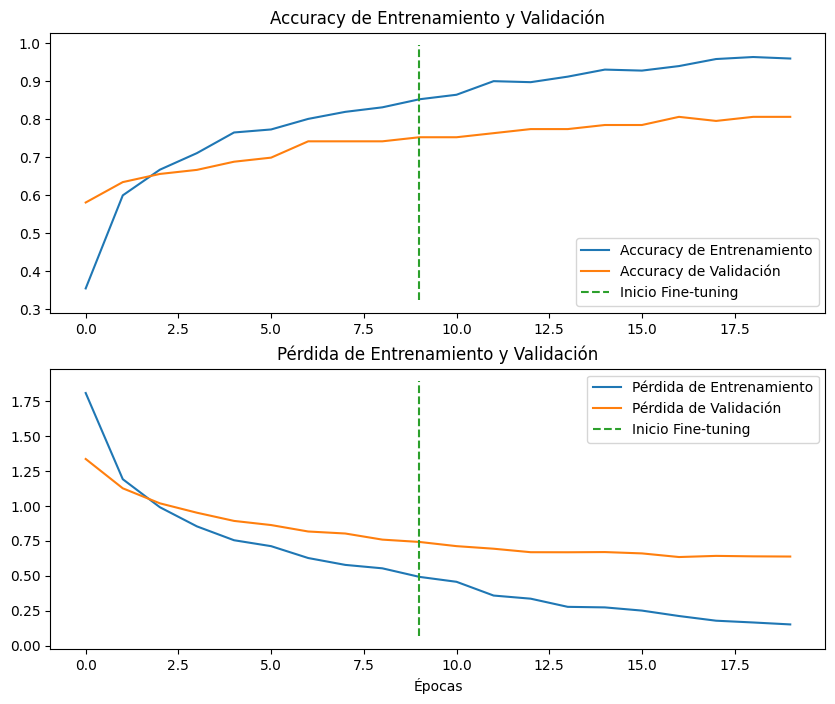

In [92]:
# --- 10. Visualizar el Historial de Entrenamiento ---
def plot_history(history_initial, history_fine_tune):
    acc = history_initial.history["accuracy"] + history_fine_tune.history["accuracy"]
    val_acc = (
        history_initial.history["val_accuracy"]
        + history_fine_tune.history["val_accuracy"]
    )
    loss = history_initial.history["loss"] + history_fine_tune.history["loss"]
    val_loss = (
        history_initial.history["val_loss"] + history_fine_tune.history["val_loss"]
    )

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Accuracy de Entrenamiento")
    plt.plot(val_acc, label="Accuracy de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="lower right")
    plt.title("Accuracy de Entrenamiento y Validación")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Pérdida de Entrenamiento")
    plt.plot(val_loss, label="Pérdida de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.xlabel("Épocas")
    plt.show()


plot_history(history_initial, history_fine_tune)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


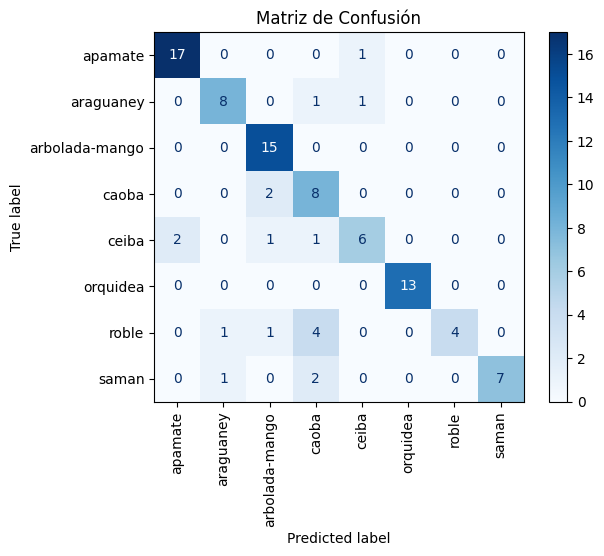

In [93]:
# Ver matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.argmax(axis=1))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(model, test_ds)